In [1]:
import os
import glob
import numpy as np
import bokeh.io
import bokeh.plotting
import bokeh.palettes
from bokeh.transform import jitter
import seaborn as sns
import matplotlib
from bokeh.models import HoverTool
from scipy import stats
import pandas as pd
import bokeh_catplot
import math

from bokeh.layouts import row
bokeh.io.output_notebook()

C:\ProgramData\Anaconda3\lib\site-packages\bokeh_catplot\__init__.py:13: DeprecationWarning: bokeh-catplot is deprecated. Use iqplot instead.
  warnings.warn("bokeh-catplot is deprecated. Use iqplot instead.", DeprecationWarning)


Loading BokehJS ...

In [2]:
#Functions
def bootstrap_sampling(my_array, bootstrap_samples, bootstrap_replicates):
    bs_samples=np.zeros((bootstrap_replicates, bootstrap_samples))
    bs_rep=np.arange(bootstrap_replicates)
    for i in bs_rep:
        bs_samples[i, :]=np.random.choice(my_array, bootstrap_samples)
    return bs_samples

def bootstrap_stats(bs_samples):
    samples_shape=np.shape(bs_samples)
    bs_means=np.zeros((samples_shape[0], 1))
    bs_IC_means=np.zeros((1, 2))
    bs_medians=np.zeros((samples_shape[0], 1))
    bs_IC_medians=np.zeros((1, 2))
    for i in np.arange(samples_shape[0]):
        bs_means[i]=np.mean(bs_samples[i, :])
        bs_medians[i]=np.median(bs_samples[i, :])
    bs_IC_means[0, 0]=np.quantile(bs_means, .025)
    bs_IC_means[0, 1]=np.quantile(bs_means, .975)
    bs_IC_medians[0, 0]=np.quantile(bs_medians, .025)
    bs_IC_medians[0, 1]=np.quantile(bs_medians, .975)
    return np.mean(bs_means), np.median(bs_medians), bs_IC_means, bs_IC_medians

def get_bootstrap_stats(df, parameterX, parameterY, tot_pili_limit):
    nb_pili=np.zeros((tot_pili_limit, 1))
    boot_mean=np.zeros((tot_pili_limit, 1))
    boot_median=np.zeros((tot_pili_limit, 1))
    boot_IC_mean=np.zeros((tot_pili_limit, 2))
    boot_IC_median=np.zeros((tot_pili_limit, 2))
    for n_pili in range(tot_pili_limit):
        Pole_fluorescence_array=df.loc[(df[parameterX]==n_pili), parameterY].values
        nb_pili[n_pili]=n_pili
        if (len(Pole_fluorescence_array) > 0):
            bs_fluorescence_array=bootstrap_sampling(Pole_fluorescence_array, len(Pole_fluorescence_array), 1000)
            [bs_means, bs_medians, IC_means, IC_medians]=bootstrap_stats(bs_fluorescence_array)
            boot_mean[n_pili]=bs_means
            boot_IC_mean[n_pili,:]=IC_means
            boot_median[n_pili]=bs_medians
            boot_IC_median[n_pili,:]=IC_medians
    names = ['TotalPili', 'bootMean','bootMedian']
    data = np.concatenate((nb_pili, boot_mean, boot_median), axis=1)
    df_boot_stats_tot=pd.DataFrame(data=np.transpose(data), index=names).T
    df_boot_stats_tot['IC_mean']=list(boot_IC_mean)
    df_boot_stats_tot['IC_median']=list(boot_IC_median)
    return df_boot_stats_tot

def getDataFrame(csv_file, tot_pili_limit):
    df_full= pd.read_csv(csv_file, sep=',', na_values='*')
    df_full['PoleRange']=df_full['AreaPoleDim']/df_full['CellArea']
    pole_range=0.15 #df.PoleRange.mean()
    print(pole_range)
    ref_ratio = (2*pole_range)/(1-2*pole_range)
    df_full['PercentTotalFluoDim']=df_full['TotalFluorescencePoleDim']/df_full['CellTotalFluorescence']
    df_full['PercentTotalFluoBright']=df_full['TotalFluorescencePoleBright']/df_full['CellTotalFluorescence']
    df_full['PercentTotalFluoCenter']=(df_full['CellTotalFluorescence']-df_full['TotalFluorescencePoleBright']-df_full['TotalFluorescencePoleDim'])/df_full['CellTotalFluorescence']
    #df['polar_ratio']=(df['TotalFluorescencePoleDim']+df['TotalFluorescencePoleBright'])/(df['CellTotalFluorescence']-(df['TotalFluorescencePoleDim']+df['TotalFluorescencePoleBright']))/((2*df['PoleRange']/(1-2*df['PoleRange'])))
    df_full['polar_ratio']=((df_full['TotalFluorescencePoleDim']+df_full['TotalFluorescencePoleBright'])/(df_full['CellTotalFluorescence']-(df_full['TotalFluorescencePoleDim']+df_full['TotalFluorescencePoleBright'])))/ref_ratio
    df_full['TotalPili']=df_full['Nb_Pili_PoleDim']+df_full['Nb_Pili_PoleBright']
    df_full['TotalFlagella']=df_full['Nb_Flagella_PoleDim']+df_full['Nb_Flagella_PoleBright']
    df_full['TotalFluoPole']=df_full['TotalFluorescencePoleDim']+df_full['TotalFluorescencePoleBright']
    y_param1='Nb_Pili_PoleDim'
    y_param2='Nb_Pili_PoleBright'
    x_param1='TotalFluorescencePoleDim'
    x_param2='TotalFluorescencePoleBright'
    parameterX='TotalPili'
    parameterY='PoleTotalFluorescence'
    df=df_full.loc[df_full[parameterX]<tot_pili_limit]
    poles_pili_dim=list(df[y_param1])
    poles_pili_bright=list(df[y_param2])
    poles_pili=poles_pili_dim+poles_pili_bright
    poles_pili=np.asarray(poles_pili).reshape(len(poles_pili),1)
    poles_fluo_dim=list(df[x_param1])
    poles_fluo_bright=list(df[x_param2])
    poles_fluo=poles_fluo_dim+poles_fluo_bright
    poles_fluo=np.asarray(poles_fluo).reshape(len(poles_fluo),1)
    names = [parameterX, parameterY]
    data = np.concatenate((poles_pili, poles_fluo), axis=1)
    df_long=pd.DataFrame(data=np.transpose(data), index=names).T
    y_param1='Nb_Pili_PoleDim'
    y_param2='Nb_Pili_PoleBright'
    Ncells_per_pili_Dim=np.empty((tot_pili_limit), dtype='int16')
    Ncells_per_pili_Bright=np.empty((tot_pili_limit), dtype='int16')
    N=len(df)
    print(df.Strain.unique()[0])
    print('Dim pole:')
    print('NCells='+str(N), end=', ')
    for i in range(tot_pili_limit):
        Ncells_per_pili_Dim[i]=len(df.loc[(df[y_param1]==i)])
        if (i<tot_pili_limit-1):
            print('N_'+str(i)+'pili='+str(Ncells_per_pili_Dim[i]), end=', ')
        else: print('N_'+str(i)+'pili='+str(Ncells_per_pili_Dim[i]))
    print('Bright pole:')
    print('Ncells='+str(N), end=', ')
    for i in range(tot_pili_limit):
        Ncells_per_pili_Bright[i]=len(df.loc[(df[y_param2]==i)])
        if (i<tot_pili_limit-1):
            print('N_'+str(i)+'pili='+str(Ncells_per_pili_Bright[i]), end=', ')
        else: print('N_'+str(i)+'pili='+str(Ncells_per_pili_Bright[i]))
    nb_pili=np.zeros((tot_pili_limit, 1))
    boot_mean=np.zeros((tot_pili_limit, 1))
    boot_median=np.zeros((tot_pili_limit, 1))
    boot_IC_mean=np.zeros((tot_pili_limit, 2))
    boot_IC_median=np.zeros((tot_pili_limit, 2))
    for n_pili in range(tot_pili_limit):
        Pole_fluorescence_array=df_long.PoleTotalFluorescence.loc[(df_long[parameterX]==n_pili)].values
        nb_pili[n_pili]=n_pili
        if (len(Pole_fluorescence_array) > 0):
            bs_fluorescence_array=bootstrap_sampling(Pole_fluorescence_array, len(Pole_fluorescence_array), 1000)
            [bs_means, bs_medians, IC_means, IC_medians]=bootstrap_stats(bs_fluorescence_array)
            boot_mean[n_pili]=bs_means
            boot_IC_mean[n_pili,:]=IC_means
            boot_median[n_pili]=bs_medians
            boot_IC_median[n_pili,:]=IC_medians
    names = ['TotalPili', 'bootMean','bootMedian']
    data = np.concatenate((nb_pili, boot_mean, boot_median), axis=1)
    df_boot_stats_tot=pd.DataFrame(data=np.transpose(data), index=names).T
    df_boot_stats_tot['IC_mean']=list(boot_IC_mean)
    df_boot_stats_tot['IC_median']=list(boot_IC_median)
    return df, df_long, df_boot_stats_tot

def plotData(df, df_long, df_boot_stats_tot, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1):
    p3 = bokeh.plotting.figure(
        width=600, 
        height=600, 
        x_axis_label='# pili', 
        y_axis_type='linear',
        y_range=Yrange,
        x_range=Xrange,
        y_axis_label ='pole fluorescence',
        title=str(df.Strain.unique()[0])+" pole total fluorescence vs # pili (bootstrap median, 95% CI)"
    )
    p3.circle(
        source=df_long,
        x=parameterX,
        y=parameterY, 
        line_color = 'green',
        fill_color = 'white',
        alpha=0.4,
        #legend = labelsAll[i]
    )
    for n_pili in list(df_boot_stats_tot[param2]):
        b = [n_pili,n_pili]
        ic=df_boot_stats_tot.loc[(df_boot_stats_tot[param2] == n_pili), [IC1]].values[0][0]
        p3.line(
            x = b,
            y = ic,
            color = 'black',
            alpha=0.7,
            line_width=3
        )
    #p3.line(
     #   source = df_boot_stats_tot.loc[:, [param2, param1]],
      #  x = param2,
       # y = param1,
       # line_color = 'black',
      #  alpha=0.6
    #)
    p3.circle(
        source = df_boot_stats_tot.loc[:, [param2, param1]],
        x = param2,
        y = param1,
        line_color = 'black',
        fill_color = 'white',
        alpha=0.6,
        size=10
    )
    p3.output_backend = 'svg'
    return p3

def plotPolarRatios(df_pilH, parameter):
    XRANGE=['Liquid', 'Solid']
    df_pilH['X_values']=0.0
    liq_empty=False
    sol_empty=False
    if df_pilH.loc[df_pilH['Growth']=='Liquid', 'X_values'].empty:
        liq_empty=True
    if df_pilH.loc[df_pilH['Growth']=='Solid', 'X_values'].empty:
        sol_empty=True
    if ((liq_empty or sol_empty) == False):
        df_pilH.loc[df_pilH['Growth']=='Liquid', 'X_values']=0.5
        df_pilH.loc[df_pilH['Growth']=='Solid', 'X_values']=1.5
        liq_array=df_pilH[parameter].loc[(df_pilH['Growth']=='Liquid')].values
        bs_liq_array=bootstrap_sampling(liq_array, len(liq_array), 1000)
        [bs_means_liq, bs_medians_liq, IC_means_liq, IC_medians_liq]=bootstrap_stats(bs_liq_array)
        sol_array=df_pilH[parameter].loc[(df_pilH['Growth']=='Solid')].values
        bs_sol_array=bootstrap_sampling(sol_array, len(sol_array), 1000)
        [bs_means_sol, bs_medians_sol, IC_means_sol, IC_medians_sol]=bootstrap_stats(bs_sol_array)
        p3 = bokeh.plotting.figure(
            width=400, 
            height=400, 
            y_axis_type='linear',
            y_range=[0,2],
            x_range=XRANGE,
            y_axis_label ='Polarization Index',
            title=str(df_pilH.Strain.unique()[0])+" Polarization Index (bootstrap median, 95% CI)"
        )
        p3.circle(
            source=df_pilH.loc[df_pilH['Growth']=='Liquid'],
            x=jitter('X_values', width=0.3, range=p3.y_range),
            y=parameter, 
            line_color = 'darkgrey',
            fill_color = 'darkgrey',
            alpha=0.8,
            #legend = labelsAll[i]
        )
        b = ['Liquid','Liquid']
        ic=IC_medians_liq[0] 
        p3.line(
            x = b,
            y = ic,
            color = 'black',
            alpha=1,
            line_width=4
        )
        p3.circle(
            x=0.5,
            y=bs_medians_liq, 
            line_color = 'black',
            fill_color = 'white',
            alpha=1,
            size=10
            #legend = labelsAll[i]
        )
        p3.circle(
            source=df_pilH.loc[df_pilH['Growth']=='Solid'],
            x=jitter('X_values', width=0.3, range=p3.y_range),
            y=parameter, 
            line_color = 'grey',
            fill_color = 'grey',
            alpha=0.8,
            #legend = labelsAll[i]
        )
        b = ['Solid','Solid']
        ic=IC_medians_sol[0] 
        p3.line(
            x = b,
            y = ic,
            color = 'black',
            alpha=1,
            line_width=4
        )
        p3.circle(
            x=1.5,
            y=bs_medians_sol, 
            line_color = 'black',
            fill_color = 'white',
            alpha=1,
            size=10
            #legend = labelsAll[i]
        )
        #p3.xaxis.major_label_orientation = math.pi/4
        p3.xaxis.major_label_text_font_size = "14pt"
        p3.output_backend = 'svg'
        return p3
    elif (liq_empty==True):
        XRANGE=['Liquid','Solid']
        print('PilG in')
        df_pilH.loc[df_pilH['Growth']=='Solid', 'X_values']=1.5
        sol_array=df_pilH[parameter].loc[(df_pilH['Growth']=='Solid')].values
        bs_sol_array=bootstrap_sampling(sol_array, len(sol_array), 1000)
        [bs_means_sol, bs_medians_sol, IC_means_sol, IC_medians_sol]=bootstrap_stats(bs_sol_array)
        p3 = bokeh.plotting.figure(
            width=400, 
            height=400, 
            y_axis_type='linear',
            y_range=[0,2],
            x_range=XRANGE,
            y_axis_label ='Polarization Index',
            title=str(df_pilH.Strain.unique()[0])+" Polarization Index (bootstrap median, 95% CI)"
        )
        p3.circle(
            source=df_pilH.loc[df_pilH['Growth']=='Solid'],
            x=jitter('X_values', width=0.3, range=p3.y_range),
            y=parameter, 
            line_color = 'grey',
            fill_color = 'grey',
            alpha=0.8,
            #legend = labelsAll[i]
        )
        b = ['Solid','Solid']
        ic=IC_medians_sol[0] 
        p3.line(
            x = b,
            y = ic,
            color = 'black',
            alpha=1,
            line_width=4
        )
        p3.circle(
            x=1.5,
            y=bs_medians_sol, 
            line_color = 'black',
            fill_color = 'white',
            alpha=1,
            size=10
            #legend = labelsAll[i]
        )
        #p3.xaxis.major_label_orientation = math.pi/4
        p3.xaxis.major_label_text_font_size = "14pt"
        p3.output_backend = 'svg'
        return p3

def plot_parameters(df, df_short, df_boot_stats_tot, tot_pili_limit, y_range, parameterX, parameterY, param1, param2, IC1, scale):
    p3 = bokeh.plotting.figure(
        width=600, 
        height=600, 
        x_axis_label=parameterX, 
        y_axis_type=scale,
        y_range=[0,y_range],
        x_range=[-0.5,tot_pili_limit-0.5],
        y_axis_label =parameterY,
        title=str(df_pilH.Strain.unique()[0])+" "+parameterY+" vs "+parameterX+" ("+param1+", 95% CI)"
    )
    p3.circle(
        source=df_short_pilH,
        x=parameterX,
        y=parameterY, 
        line_color = 'green',
        fill_color = 'white',
        alpha=0.4,
        #legend = labelsAll[i]
    )
    for n_pili in list(df_boot_stats_tot[param2]):
            b = [n_pili,n_pili]
            ic=df_boot_stats_tot.loc[(df_boot_stats_tot[param2] == n_pili), [IC1]].values[0][0]
            p3.line(
                x = b,
                y = ic,
                color = 'black',
                alpha=0.7,
                line_width=3
            )
    p3.circle(
        source = df_boot_stats_tot.loc[:, [param2, param1]],
        x = param2,
        y = param1,
        line_color = 'black',
        fill_color = 'white',
        alpha=0.6,
        size=10
    )
    p3.output_backend = 'svg'
    return p3

def persentage_difference(df):
    NPili_DimPole=np.array(df.Nb_Pili_PoleDim)
    NPili_BrightPole=np.array(df.Nb_Pili_PoleBright)
    raw_fluo_diff=(np.array(df.TotalFluorescencePoleBright)-np.array(df.TotalFluorescencePoleDim))#/np.array(df.CellTotalFluorescence)
    raw_pili_nb_diff=(NPili_BrightPole-NPili_DimPole)
    pili_nb_diff=[]
    fluo_diff=[]
    cells_morePiliBright=[]
    cells_morePiliDim=[]                                                     
    cells_samePili=[]
    for i in range(len(NPili_DimPole)):
        #print(str(NPili_BrightPole[i]!=0) +" and "+ str(NPili_DimPole[i] != 0) + " makes " + str((NPili_BrightPole[i]!=0 or NPili_DimPole[i] != 0)))
        if(NPili_BrightPole[i]!=0 or NPili_DimPole[i] != 0):
            pili_nb_diff.append(NPili_BrightPole[i]-NPili_DimPole[i])
            fluo_diff.append(raw_fluo_diff[i])
            if(NPili_BrightPole[i] > NPili_DimPole[i]):
                cells_morePiliBright.append(1)
                cells_morePiliDim.append(0)
                cells_samePili.append(0)
            elif (NPili_BrightPole[i] < NPili_DimPole[i]):
                cells_morePiliBright.append(0)
                cells_morePiliDim.append(1)
                cells_samePili.append(0)
            else:
                cells_morePiliBright.append(0)
                cells_morePiliDim.append(0)
                cells_samePili.append(1)
    N_cells_morePiliBright=sum(cells_morePiliBright)
    N_cells_morePiliDim=sum(cells_morePiliDim)
    N_cells_samePili=sum(cells_samePili)
    #n=len(NPili_DimPole)
    n=len(cells_morePiliBright)
    persentage_piliBright=N_cells_morePiliBright/n
    persentage_piliDim=N_cells_morePiliDim/n
    persentage_samepili=N_cells_samePili/n
    return persentage_piliBright, persentage_piliDim, persentage_samepili, N_cells_morePiliBright, N_cells_morePiliDim, N_cells_samePili, n, pili_nb_diff, raw_fluo_diff


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
data_path="C:/users/lorenzo/Desktop/git/PhD_codes/Mechanosensation/Python_code/Pole_analysis/Combined_Data"
os.chdir(data_path)
extension = 'csv'
list_csv = []
for root, dirs, files in os.walk(data_path, topdown=False):
    for name in files:
        if extension in name:
            list_csv.append(name)
tot_pili_limit=11
parameterX='TotalPili'
parameterY='PoleTotalFluorescence'
df_pilB, df_long_pilB, df_boot_stats_tot_pilB= getDataFrame('PolesData_pilB_mNG_fliC-_combined.csv', tot_pili_limit)
print('')
df_pilH, df_long_pilH, df_boot_stats_tot_pilH= getDataFrame('PolesData_mNG_pilH_fliC-_combined.csv', tot_pili_limit)
print('')
df_pilT, df_long_pilT, df_boot_stats_tot_pilT= getDataFrame('PolesData_mNG_pilT_fliC-_combined.csv', tot_pili_limit)
print('')
df_pilU, df_long_pilU, df_boot_stats_tot_pilU= getDataFrame('PolesData_mNG_pilU_fliC-_combined.csv', tot_pili_limit)
print('')
df_pilG, df_long_pilG, df_boot_stats_tot_pilG= getDataFrame('PolesData_mNG_pilG_fliC-_combined.csv', tot_pili_limit)

0.15
pilB_mNG_fliC-
Dim pole:
NCells=119, N_0pili=83, N_1pili=28, N_2pili=6, N_3pili=2, N_4pili=0, N_5pili=0, N_6pili=0, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0
Bright pole:
Ncells=119, N_0pili=66, N_1pili=38, N_2pili=8, N_3pili=4, N_4pili=0, N_5pili=2, N_6pili=1, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0

0.15
mNG_pilH_fliC-
Dim pole:
NCells=150, N_0pili=87, N_1pili=21, N_2pili=21, N_3pili=6, N_4pili=7, N_5pili=3, N_6pili=3, N_7pili=0, N_8pili=2, N_9pili=0, N_10pili=0
Bright pole:
Ncells=150, N_0pili=65, N_1pili=23, N_2pili=15, N_3pili=12, N_4pili=13, N_5pili=8, N_6pili=8, N_7pili=0, N_8pili=2, N_9pili=2, N_10pili=2

0.15
mNG_pilT_fliC-
Dim pole:
NCells=133, N_0pili=80, N_1pili=26, N_2pili=13, N_3pili=7, N_4pili=3, N_5pili=3, N_6pili=1, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0
Bright pole:
Ncells=133, N_0pili=78, N_1pili=30, N_2pili=14, N_3pili=7, N_4pili=4, N_5pili=0, N_6pili=0, N_7pili=0, N_8pili=0, N_9pili=0, N_10pili=0

0.15
mNG_pilU_fliC-
Dim pole:
NCells=113, N_0pili=56

In [4]:
param2='TotalPili'
IC1='IC_median'
param1='bootMedian'
Yrange=[0, 100000]
Xrange=[-0.6, tot_pili_limit-1+0.6]
p_pilB=plotData(df_pilB, df_long_pilB, df_boot_stats_tot_pilB, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
p_pilH=plotData(df_pilH, df_long_pilH, df_boot_stats_tot_pilH, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
p_pilT=plotData(df_pilT, df_long_pilT, df_boot_stats_tot_pilT, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
p_pilU=plotData(df_pilU, df_long_pilU, df_boot_stats_tot_pilU, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
p_pilG=plotData(df_pilG, df_long_pilG, df_boot_stats_tot_pilG, Xrange, Yrange, parameterX, parameterY, param1, param2, IC1)
bokeh.io.show(row(p_pilB, p_pilT, p_pilU))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
bokeh.io.show(row(p_pilH, p_pilG))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
parameter = 'PolarRatio'
p_rat_pilH=plotPolarRatios(df_pilH, parameter)
p_rat_pilB=plotPolarRatios(df_pilB, parameter)
p_rat_pilT=plotPolarRatios(df_pilT, parameter)
p_rat_pilU=plotPolarRatios(df_pilU, parameter)
p_rat_pilG=plotPolarRatios(df_pilG, parameter)
bokeh.io.show(row(p_rat_pilB, p_rat_pilT, p_rat_pilU))

PilG in


In [7]:
bokeh.io.show(p_rat_pilG)
df_pilG.head(100)

,,Label,Area,Mean,Min,Max,X,Y,BiologicalReplicate,CellArea,...,Growth,PoleRange,PercentTotalFluoDim,PercentTotalFluoBright,PercentTotalFluoCenter,polar_ratio,TotalPili,TotalFlagella,TotalFluoPole,X_values
0,1,mNG_pilG_fliC-_sol_Gasket_0_event10_tirf_RAW_S...,792,255,255,255,36.07197,39.72980,1,889,...,Solid,0.175478,0.152293,0.220125,0.627582,1.384638,0,0,17558.0,1.5
1,1,mNG_pilG_fliC-_sol_Gasket_0_event11_tirf_RAW_S...,1101,255,255,255,45.59173,37.85604,1,1217,...,Solid,0.170912,0.179233,0.189741,0.631027,1.364344,0,0,21068.0,1.5
2,2,mNG_pilG_fliC-_sol_Gasket_0_event11_tirf_RAW_S...,993,255,255,255,35.93202,51.36606,1,1107,...,Solid,0.140921,0.189835,0.205839,0.604326,1.527720,1,0,27863.0,1.5
3,1,mNG_pilG_fliC-_sol_Gasket_0_event12_tirf_RAW_S...,714,255,255,255,34.61765,40.53782,1,801,...,Solid,0.220974,0.234432,0.240326,0.525242,2.109065,0,0,15705.0,1.5
4,2,mNG_pilG_fliC-_sol_Gasket_0_event12_tirf_RAW_S...,605,255,255,255,21.11818,42.91653,1,676,...,Solid,0.230769,0.264335,0.287087,0.448578,2.868288,1,0,39264.0,1.5
5,1,mNG_pilG_fliC-_sol_Gasket_0_event13_tirf_RAW_S...,832,255,255,255,35.00361,42.54567,1,926,...,Solid,0.191145,0.224453,0.242542,0.533005,2.044362,1,0,28631.0,1.5
6,2,mNG_pilG_fliC-_sol_Gasket_0_event13_tirf_RAW_S...,1244,255,255,255,56.26286,46.13424,1,1394,...,Solid,0.098278,0.187136,0.192515,0.620349,1.427989,4,0,33030.0,1.5
7,1,mNG_pilG_fliC-_sol_Gasket_0_event14_tirf_RAW_S...,1189,255,255,255,22.98696,66.12489,1,1312,...,Solid,0.104421,0.134480,0.154454,0.711066,0.948124,6,0,23911.0,1.5
8,1,mNG_pilG_fliC-_sol_Gasket_0_event15_tirf_RAW_S...,1173,255,255,255,45.95951,41.42072,1,1309,...,Solid,0.074102,0.058792,0.062056,0.879152,0.320740,3,0,7848.0,1.5
9,1,mNG_pilG_fliC-_sol_Gasket_0_event16_tirf_RAW_S...,825,255,255,255,45.06121,21.33030,1,918,...,Solid,0.149237,0.121928,0.175177,0.702895,0.986271,3,0,21336.0,1.5


In [8]:
parameter = 'polar_ratio'
p_rat_pilH=plotPolarRatios(df_pilH, parameter)
p_rat_pilB=plotPolarRatios(df_pilB, parameter)
p_rat_pilT=plotPolarRatios(df_pilT, parameter)
p_rat_pilU=plotPolarRatios(df_pilU, parameter)
p_rat_pilG=plotPolarRatios(df_pilG, parameter)
bokeh.io.show(row(p_rat_pilG, p_rat_pilB, p_rat_pilT, p_rat_pilU))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PilG in


In [9]:
df_long_pilH.head()

,TotalPili,PoleTotalFluorescence
0,0.0,43924.0
1,0.0,32803.0
2,0.0,39955.0
3,2.0,43538.0
4,0.0,31374.0


In [10]:
print(parameterY+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_long_pilH[parameterY], df_long_pilH[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_long_pilH[parameterY], df_long_pilH[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

PoleTotalFluorescence vs TotalPili:
Spearman correlation = 0.46800254539097924, p-value = 9.817924016217432e-18
Pearson correlation = 0.45411152971196606, p-value = 1.1414165391384808e-16


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
df_boot_stats_tot_pilH.head(100)
df_boot_stats_tot_pilH.to_csv( "boot_Pili_pilH_Data.csv", index=False, encoding='utf-8-sig')

In [12]:
param3='bootMedian'
print(param3+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_boot_stats_tot_pilH[param3], df_boot_stats_tot_pilH[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_boot_stats_tot_pilH[param3], df_boot_stats_tot_pilH[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

bootMedian vs TotalPili:
Spearman correlation = 0.4909090909090909, p-value = 0.12520440713849534
Pearson correlation = 0.15561861948501696, p-value = 0.6477394859022265


In [13]:
columns_name =  {0 : 'TotalPili',
                1 : 'TotalFluoPole',
                2 : 'PolarRatio'}
df_short_pilH=pd.DataFrame(zip(df_pilH.TotalPili, df_pilH.TotalFluoPole, df_pilH.PolarRatio)).rename(columns=columns_name)

df_pilH_bootStats_TotalFluoPole=get_bootstrap_stats(df_short_pilH, parameterX, 'TotalFluoPole', tot_pili_limit)
df_pilH_bootStats_PolarRatio=get_bootstrap_stats(df_short_pilH, parameterX, 'PolarRatio', tot_pili_limit)




In [14]:
p_fluo=plot_parameters(df_pilH, df_short_pilH, df_pilH_bootStats_TotalFluoPole, tot_pili_limit, 150000, parameterX, 'TotalFluoPole', param1, param2, 'IC_median', 'linear')
bokeh.io.show(p_fluo)
parameterY='TotalFluoPole'

print(parameterY+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_short_pilH[parameterY], df_short_pilH[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_short_pilH[parameterY], df_short_pilH[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

param3='bootMedian'
print(param3+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_pilH_bootStats_TotalFluoPole[param3], df_pilH_bootStats_TotalFluoPole[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_pilH_bootStats_TotalFluoPole[param3], df_pilH_bootStats_TotalFluoPole[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TotalFluoPole vs TotalPili:
Spearman correlation = 0.5400389062524438, p-value = 9.898863838132704e-13
Pearson correlation = 0.5314210561236893, p-value = 2.621142415869763e-12
bootMedian vs TotalPili:
Spearman correlation = 0.8454545454545455, p-value = 0.0010451821458586869
Pearson correlation = 0.8635564732321203, p-value = 0.000613234267628062


In [15]:
p_polar=plot_parameters(df_pilH, df_short_pilH, df_pilH_bootStats_PolarRatio, tot_pili_limit, 3, parameterX, 'PolarRatio', param1, param2, 'IC_median', 'linear')
bokeh.io.show(p_polar)

parameterY='PolarRatio'

print(parameterY+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_short_pilH[parameterY], df_short_pilH[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_short_pilH[parameterY], df_short_pilH[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

param3='bootMedian'
print(param3+' vs '+parameterX+':')

[spearman_r, spearman_p]=stats.spearmanr(df_pilH_bootStats_PolarRatio[param3], df_pilH_bootStats_PolarRatio[parameterX])
print('Spearman correlation = '+str(spearman_r)+', p-value = '+ str(spearman_p))

[pearson_r, pearson_p]=stats.pearsonr(df_pilH_bootStats_PolarRatio[param3], df_pilH_bootStats_PolarRatio[parameterX])
print('Pearson correlation = '+str(pearson_r)+', p-value = '+str(pearson_p))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PolarRatio vs TotalPili:
Spearman correlation = 0.2523772240325776, p-value = 0.0018349899417308792
Pearson correlation = 0.3530192850744125, p-value = 9.382813441547735e-06
bootMedian vs TotalPili:
Spearman correlation = 0.5, p-value = 0.11730680301423815
Pearson correlation = 0.6208448853666338, p-value = 0.04150678649569554


In [16]:
df_pilH['piliB_piliD']=df_pilH['Nb_Pili_PoleBright']-df_pilH['Nb_Pili_PoleDim']
df_pilH['piliB_piliD_over_Tot']=df_pilH['piliB_piliD']/df_pilH['TotalPili']
df_pilH['fluoB_fluoD']=df_pilH['TotalFluorescencePoleBright']-df_pilH['TotalFluorescencePoleDim']
df_pilH['fluoB_fluoD_over_totFluoPole']=df_pilH['fluoB_fluoD']/(df_pilH['TotalFluorescencePoleBright']+df_pilH['TotalFluorescencePoleDim'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.4434782608695653
2.0


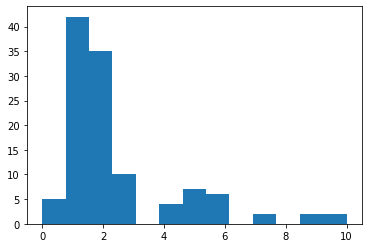

In [17]:
import matplotlib.pyplot as plt

x_pili = np.abs(df_pilH.loc[df_pilH['TotalPili']>0,'piliB_piliD'].values)
print(np.mean(x_pili))
print(np.median(x_pili))
plt.hist(x_pili, bins = 13)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.7957487922705313
1.0


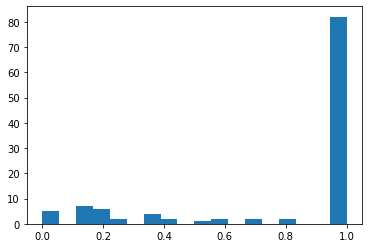

In [18]:
y_pili = np.abs(df_pilH.loc[df_pilH['TotalPili']>0,'piliB_piliD_over_Tot'].values)
print(np.mean(y_pili))
print(np.median(y_pili))
plt.hist(y_pili, bins = 18)
plt.show()

5779.452173913043
3917.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


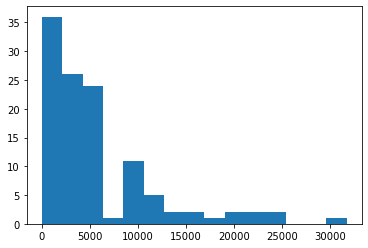

In [19]:
x_fluo = np.abs(df_pilH.loc[df_pilH['TotalPili']>0,'fluoB_fluoD'].values)
print(np.mean(x_fluo))
print(np.median(x_fluo))
plt.hist(x_fluo, bins = 15)
plt.show()

0.07209356231818483
0.05175385322456215


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


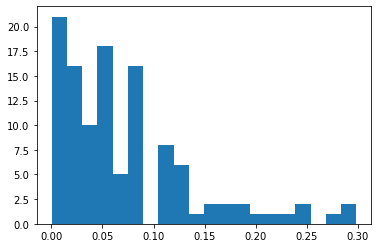

In [20]:
y_fluo = np.abs(df_pilH.loc[df_pilH['TotalPili']>0,'fluoB_fluoD_over_totFluoPole'].values)
print(np.mean(y_fluo))
print(np.median(y_fluo))
plt.hist(y_fluo, bins = 20)
plt.show()

In [21]:
p3 = bokeh.plotting.figure(
        width=600, 
        height=600, 
        x_axis_label='# pili', 
        y_axis_type='linear',
        y_axis_label ='pole fluorescence',
        title=str(df_pilH.Strain.unique()[0])+" pole total fluorescence vs # pili (bootstrap median, 95% CI)"
)
p3.circle(
    x=x_pili,
    y=x_fluo, 
    line_color = 'green',
    fill_color = 'white',
    alpha=0.4,
    #legend = labelsAll[i]
)

bokeh.io.show(p3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
p3 = bokeh.plotting.figure(
        width=600, 
        height=600, 
        x_axis_label='# pili', 
        y_axis_type='linear',
        y_axis_label ='pole fluorescence',
        title=str(df_pilH.Strain.unique()[0])+" pole total fluorescence vs # pili (bootstrap median, 95% CI)"
)
p3.circle(
    x=y_pili,
    y=y_fluo, 
    line_color = 'green',
    fill_color = 'white',
    alpha=0.4,
    #legend = labelsAll[i]
)

bokeh.io.show(p3)

In [23]:
df_pilG['X_values']=0.0